# Spaceship KNN Submission

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


# Bring the Data In

In [ ]:
# Load data
X_df = pd.read_csv('preprocessedbankchurn_train.csv')
X_df.drop("Exited", axis=1, inplace=True)
y_df = pd.read_csv('preprocessedbankchurn_train.csv')['Exited']
X_submission = pd.read_csv('preprocessedbankchurn_test.csv')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

# Model Training

Training Accuracy:  [1.0, 0.8332992493959569, 0.834518696933203, 0.8057139827459535, 0.8057594279957887, 0.7961326092390193, 0.7962234997386898, 0.7913305611730934, 0.7913532837980111, 0.7898308679285297]
Testing Accuracy:  [0.6707971036446815, 0.7649892447056685, 0.7226345926621626, 0.7708364892295574, 0.7511739933953404, 0.7779561911109765, 0.764928651498167, 0.7818341563910686, 0.7751689035659103, 0.7847729269548883]


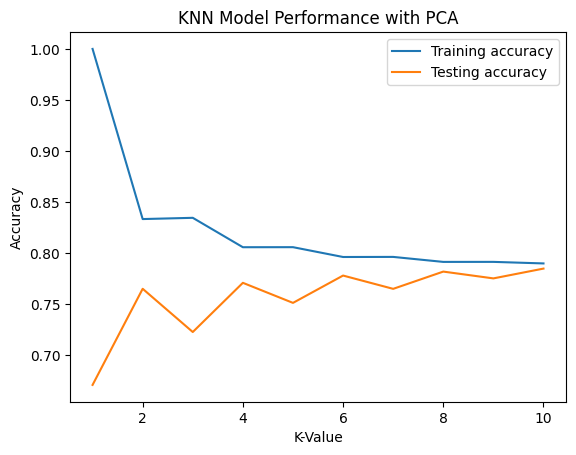

In [ ]:
pca = PCA(n_components=0.1)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Menginisialisasi nilai k yang ingin diuji
k_values = range(1, 11)
training_accuracy = []
testing_accuracy = []

# Melatih model KNN dengan PCA
for k_value in k_values:
    knn = KNeighborsClassifier(n_neighbors=k_value)
    knn.fit(X_train_pca, y_train)

    training_accuracy.append(knn.score(X_train_pca, y_train))
    testing_accuracy.append(knn.score(X_test_pca, y_test))

# Menampilkan hasil
print("Training Accuracy: ", training_accuracy)
print("Testing Accuracy: ", testing_accuracy)

# Visualisasi performa model
knn_performance = {'k_values': k_values, 'training_accuracy': training_accuracy, 'testing_accuracy': testing_accuracy}
knn_performance = pd.DataFrame(knn_performance)

# Visualisasi performa model KNN dengan PCA
sns.lineplot(data=knn_performance, x='k_values', y='training_accuracy', label='Training accuracy')
sns.lineplot(data=knn_performance, x='k_values', y='testing_accuracy', label='Testing accuracy')

plt.title("KNN Model Performance with PCA")
plt.xlabel("K-Value")
plt.ylabel("Accuracy")

plt.legend()
plt.show()



In [ ]:
# Membuat pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling sangat penting untuk KNN
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [20],
    'knn__weights': ['distance'],
    'knn__metric': ['manhattan']
}

# Menggunakan StratifiedKFold untuk handling imbalanced data
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:

# Membuat GridSearchCV
grid_search = GridSearchCV(pipeline,param_grid, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(X_train, y_train)

# Evaluate the model
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
print("Best parameters:", grid_search.best_params_)
print("ROC-AUC on test set:", roc_auc_score(y_test, y_pred_proba))


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 20, 'knn__weights': 'distance'}
ROC-AUC on test set: 0.8748304116204906


In [ ]:
# Evaluation on the test set
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Fit the model on all training data
grid_search.fit(X_df, y_df)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     26052
           1       0.73      0.50      0.59      6955

    accuracy                           0.85     33007
   macro avg       0.80      0.72      0.75     33007
weighted avg       0.84      0.85      0.84     33007

Confusion Matrix:
[[24750  1302]
 [ 3500  3455]]
Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan'], 'knn__n_neighbors': [20],
                         'knn__weights': ['distance']},
             scoring='roc_auc', verbose=1)

In [ ]:
# Predict probabilities for submission data
y_submission_proba = grid_search.predict_proba(X_submission)[:, 1]  # Probabilities of Exited
print(y_submission_proba)

# Prepare submission dictionary
submission_dict = {'id': X_submission['id'], 'Exited': y_submission_proba}
submission_dict = pd.DataFrame(submission_dict)
submission_dict

[0.04859039 0.71320667 0.         ... 0.         0.36741091 0.10307429]


,id,Exited
0,165034,0.048590
1,165035,0.713207
2,165036,0.000000
3,165037,0.090939
4,165038,0.589431
...,...,...
110018,275052,0.047802
110019,275053,0.058787
110020,275054,0.000000
110021,275055,0.367411


In [ ]:
submission_dict.to_csv('bankChurn_knn1.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2a79941c-6614-47fe-9427-0e9f23998893' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>